In [1]:
# Sys modules
import argparse
import os
import glob
import pickle
import warnings
warnings.filterwarnings("ignore")
import subprocess

# Plotting modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm

# Seismology modules
from obspy import read_events
from obspy.imaging.beachball import beach
from obspy.geodetics import kilometers2degrees
from geographiclib.geodesic import Geodesic

# Data modules
import pandas as pd

In [2]:
# load station info
StationCatalog = dict()
StationCatalog['StationName'] = []
StationCatalog['NetworkCode'] = []
StationCatalog['StationCode'] = []
StationCatalog['Channel'] = []
StationCatalog['Latitude'] = []
StationCatalog['Longitude'] = []


with open("../Data/fetch_fdsn_sxd/station.meta", 'r') as f:
    for line in f:
        StationName = line.split('|')[0] + '.' + line.split('|')[1]
        StationCatalog['StationName'].append(StationName)
        StationCatalog['NetworkCode'].append(line.split('|')[0])
        StationCatalog['StationCode'].append(line.split('|')[1])
        StationCatalog['Channel'].append(line.split('|')[3])
        StationCatalog['Latitude'].append(float(line.split('|')[4]))
        StationCatalog['Longitude'].append(float(line.split('|')[5]))

dfall = pd.DataFrame(data=StationCatalog)
df = dfall[dfall['Channel'] == "BHE"]
df

,StationName,NetworkCode,StationCode,Channel,Latitude,Longitude
2,AH.ANQ,AH,ANQ,BHE,30.58,117.02
5,AH.BAS,AH,BAS,BHE,31.47,117.38
8,AH.BEB,AH,BEB,BHE,32.91,117.30
11,AH.BZY,AH,BZY,BHE,31.40,116.22
14,AH.CHZ,AH,CHZ,BHE,32.29,118.28
...,...,...,...,...,...,...
4526,XJ.DSZ,XJ,DSZ,BHE,44.29,84.86
4529,XJ.QHA,XJ,QHA,BHE,36.51,80.66
4532,XJ.TKQP,XJ,TKQP,BHE,37.14,84.52
4535,XJ.MNBL,XJ,MNBL,BHE,37.69,85.98


In [28]:
def plot_stations(m):
    m.scatter(df['Longitude'].values,df['Latitude'].values, latlon=True,
        s=10,color='white',marker='^',alpha=1,edgecolors='k', linewidths=0.5,zorder=20)
        
def plot_sources(m, ax, plot_rays=True):
    # Define the Sources colormap
    Spectral = cm.get_cmap('Spectral',8).reversed()
    # Plot Sources Beach Ball
    CMTcatList = glob.glob('../Data/CMTSOLUTION/*.CMTSOLUTION')
    for CMTcatPath in CMTcatList[0:1]:
        CMTcat = read_events(CMTcatPath)
        emagtype = CMTcat[0].magnitudes[0].magnitude_type
        emag = CMTcat[0].magnitudes[0].mag
        elat = CMTcat[0].origins[0].latitude
        elon = CMTcat[0].origins[0].longitude
        edepth = CMTcat[0].origins[0].depth/1000
        mt = CMTcat[0].focal_mechanisms[0].moment_tensor.tensor
        fm = [mt.m_rr, mt.m_tt,mt.m_pp,mt.m_rt,mt.m_rp,mt.m_tp]
        x,y = m(elon,elat)
        color = Spectral(edepth/600)
        ballsize = emag/6.0*280000
        beachball = beach(fm, linewidth=0.5, facecolor=color, bgcolor='w', edgecolor='k', alpha=0.85, 
                xy=(x, y), width=ballsize, size=100, nofill=False, zorder=10, axes=None)
        # ax = fig.gca()
        ax.add_collection(beachball)

        if plot_rays==True:
                piercedepth = 2800
            # try:
                for index, StatInfo in df.iterrows():
                    # print(index)
                    slat, slon = StatInfo['Latitude'], StatInfo['Longitude']
                    EventStationPair = Geodesic.WGS84.Inverse(elat,elon,slat,slon, outmask=1929)
                    distm = EventStationPair['s12']
                    distdg = kilometers2degrees(distm/1.0e3)
                    # print("station distance is %.2f" %distdg)
                    if distdg<95 or distdg>140:
                        continue
                    test=['taup_pierce -mod prem -evt ' +str(elat)+ ' ' +str(elon) + ' -sta '+str(slat) + ' ' + str(slon)+
                        ' -h '+str(edepth) +'  -ph Sdiff -Pierce '+str(piercedepth)]
                    out=subprocess.check_output(test,shell=True,universal_newlines=True)
                    # print("distdg: ", distdg)
                    # print(test)
                    # print(out)
                    t= out.split()
                    if len(t)==0:
                        test=['taup_pierce -mod prem -evt ' +str(elat)+ ' ' +str(elon) + ' -sta '+str(slat) + ' ' + str(slon)+
                        ' -h '+str(edepth) +'  -ph S -Pierce '+str(piercedepth)]  
                        out=subprocess.check_output(test,shell=True,universal_newlines=True)
                        t= out.split()
                        if len(t)==0:
                            print(' Length of taup output is 0 !!')
                            sys.exit()
                    l=[x for x in range(len(t)) if t[x]==str(piercedepth)]
                    if len(l) == 0:
                        print('Pierece depth at %.1f not found' %piercedepth)
                        continue
                    # Pierepoint Location
                    pierce1lat = float(t[l[0]+2])
                    pierce1lon = float(t[l[0]+3])
                    pierce2lat = float(t[l[1]+2])
                    pierce2lon = float(t[l[1]+3])

                    event_station = Geodesic.WGS84.Inverse(elat,elon,slat,slon, outmask=1929)
                    event_pierce1 = Geodesic.WGS84.Inverse(elat,elon,pierce1lat,pierce1lon, outmask=1929)
                    event_pierce2 = Geodesic.WGS84.Inverse(elat,elon,pierce2lat,pierce2lon, outmask=1929)

                    lats = []
                    lons= []
                    for plot_distance in np.linspace(event_pierce1['a12'], event_pierce2['a12'], 20):
                        trace_location = Geodesic.WGS84.ArcDirect(elat,elon,event_station['azi1'],plot_distance, outmask=1929)
                        lats.append(trace_location['lat2'])
                        lons.append(trace_location['lon2'])   

                    m.plot(lons, lats, latlon=True, 
                        linestyle='-', alpha=0.1, color=color,zorder=200)
            # except:
            #     continue


def plot_hotspots(m, base_path = '../Data/', lon360 = False, **kwargs):
    hotspots = pickle.load(open('%s/BGPlottingData/hotspots.pkl' % (base_path), 'rb'),encoding='bytes')
    if lon360:
        hotspots[:,0] = (hotspots[:,0] + 360) % 360.0
    x, y = m(hotspots[:,0], hotspots[:,1])
    if kwargs:
        m.scatter(x, y, **kwargs)
    else:
        m.scatter(x, y)

def plot_plates(m, base_path = '../Data/', lon360 = False, **kwargs):
    for bound in ['ridge', 'transform', 'trench']:
        name, segs = pickle.load(open('%s/BGPlottingData/%s.pkl' % (base_path,bound), 'rb'),encoding='bytes')
        ind_nan, = np.nonzero(np.isnan(segs[:,0]))
        segs[ind_nan,0] = 0
        segs[ind_nan,1] = 0
        if lon360:
            segs[:,0] = (segs[:,0] + 360) % 360.0
        x, y = m(segs[:,0], segs[:,1])
        x[ind_nan] = np.nan
        y[ind_nan] = np.nan
        dx = np.abs(x[1:] - x[:-1])
        ind_jump, = np.nonzero(dx > 1000000)
        x[ind_jump] = np.nan
        if kwargs:
            m.plot(x, y, '-', **kwargs)
        else:
            m.plot(x, y, '-')

def plot_model(fname, vmin, vmax):
    # load the model data; extract the lon, lat, and dlnVs columns
    tmp = np.loadtxt(fname)
    lon = tmp[:,1].reshape((181,361))
    lat = tmp[:,2].reshape((181,361))
    dvs = tmp[:,3].reshape((181,361))
    # initialize figure and axes
    fig = plt.figure(figsize=(8,4),dpi=300)
    ax_map = fig.add_axes([0,0,0.9,1.0])
    ax_cbr = fig.add_axes([0.91,0.3,0.01,0.4])
    # set up map
    m = Basemap(projection='robin', lon_0=-180, resolution='c', ax=ax_map)
    clip_path = m.drawmapboundary()
    m.drawcoastlines()
    # m.drawparallels(np.arange(-90,90,30))
    # m.drawmeridians(np.arange(-180,180,30))
    # plot the model
    s = m.transform_scalar(dvs, lon[0,:], lat[:,0], 1000, 500)
    im = m.imshow(s, cmap=plt.cm.seismic_r, clip_path=clip_path, vmin=vmin, vmax=vmax)
    # im.set_clim(-4,4) # adjust colorbar range
    plot_stations(m)
    plot_sources(m, ax_map, plot_rays=True)
    # add plates and hotspots
    # base_path = os.path.dirname(os.path.abspath(__file__))
    # plot_plates(m, color='k')
    # plot_hotspots(m, s=30, color='m', edgecolor='k')
    # add a colorbar
    cb = plt.colorbar(im, cax=ax_cbr)
    cb.set_label('dlnVs (%)')
    # done
    # plt.show()
    # plt.savefig("../Figure/OverallRayCoverage_2800km.jpg")

Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth at 2800.0 not found
Pierece depth 

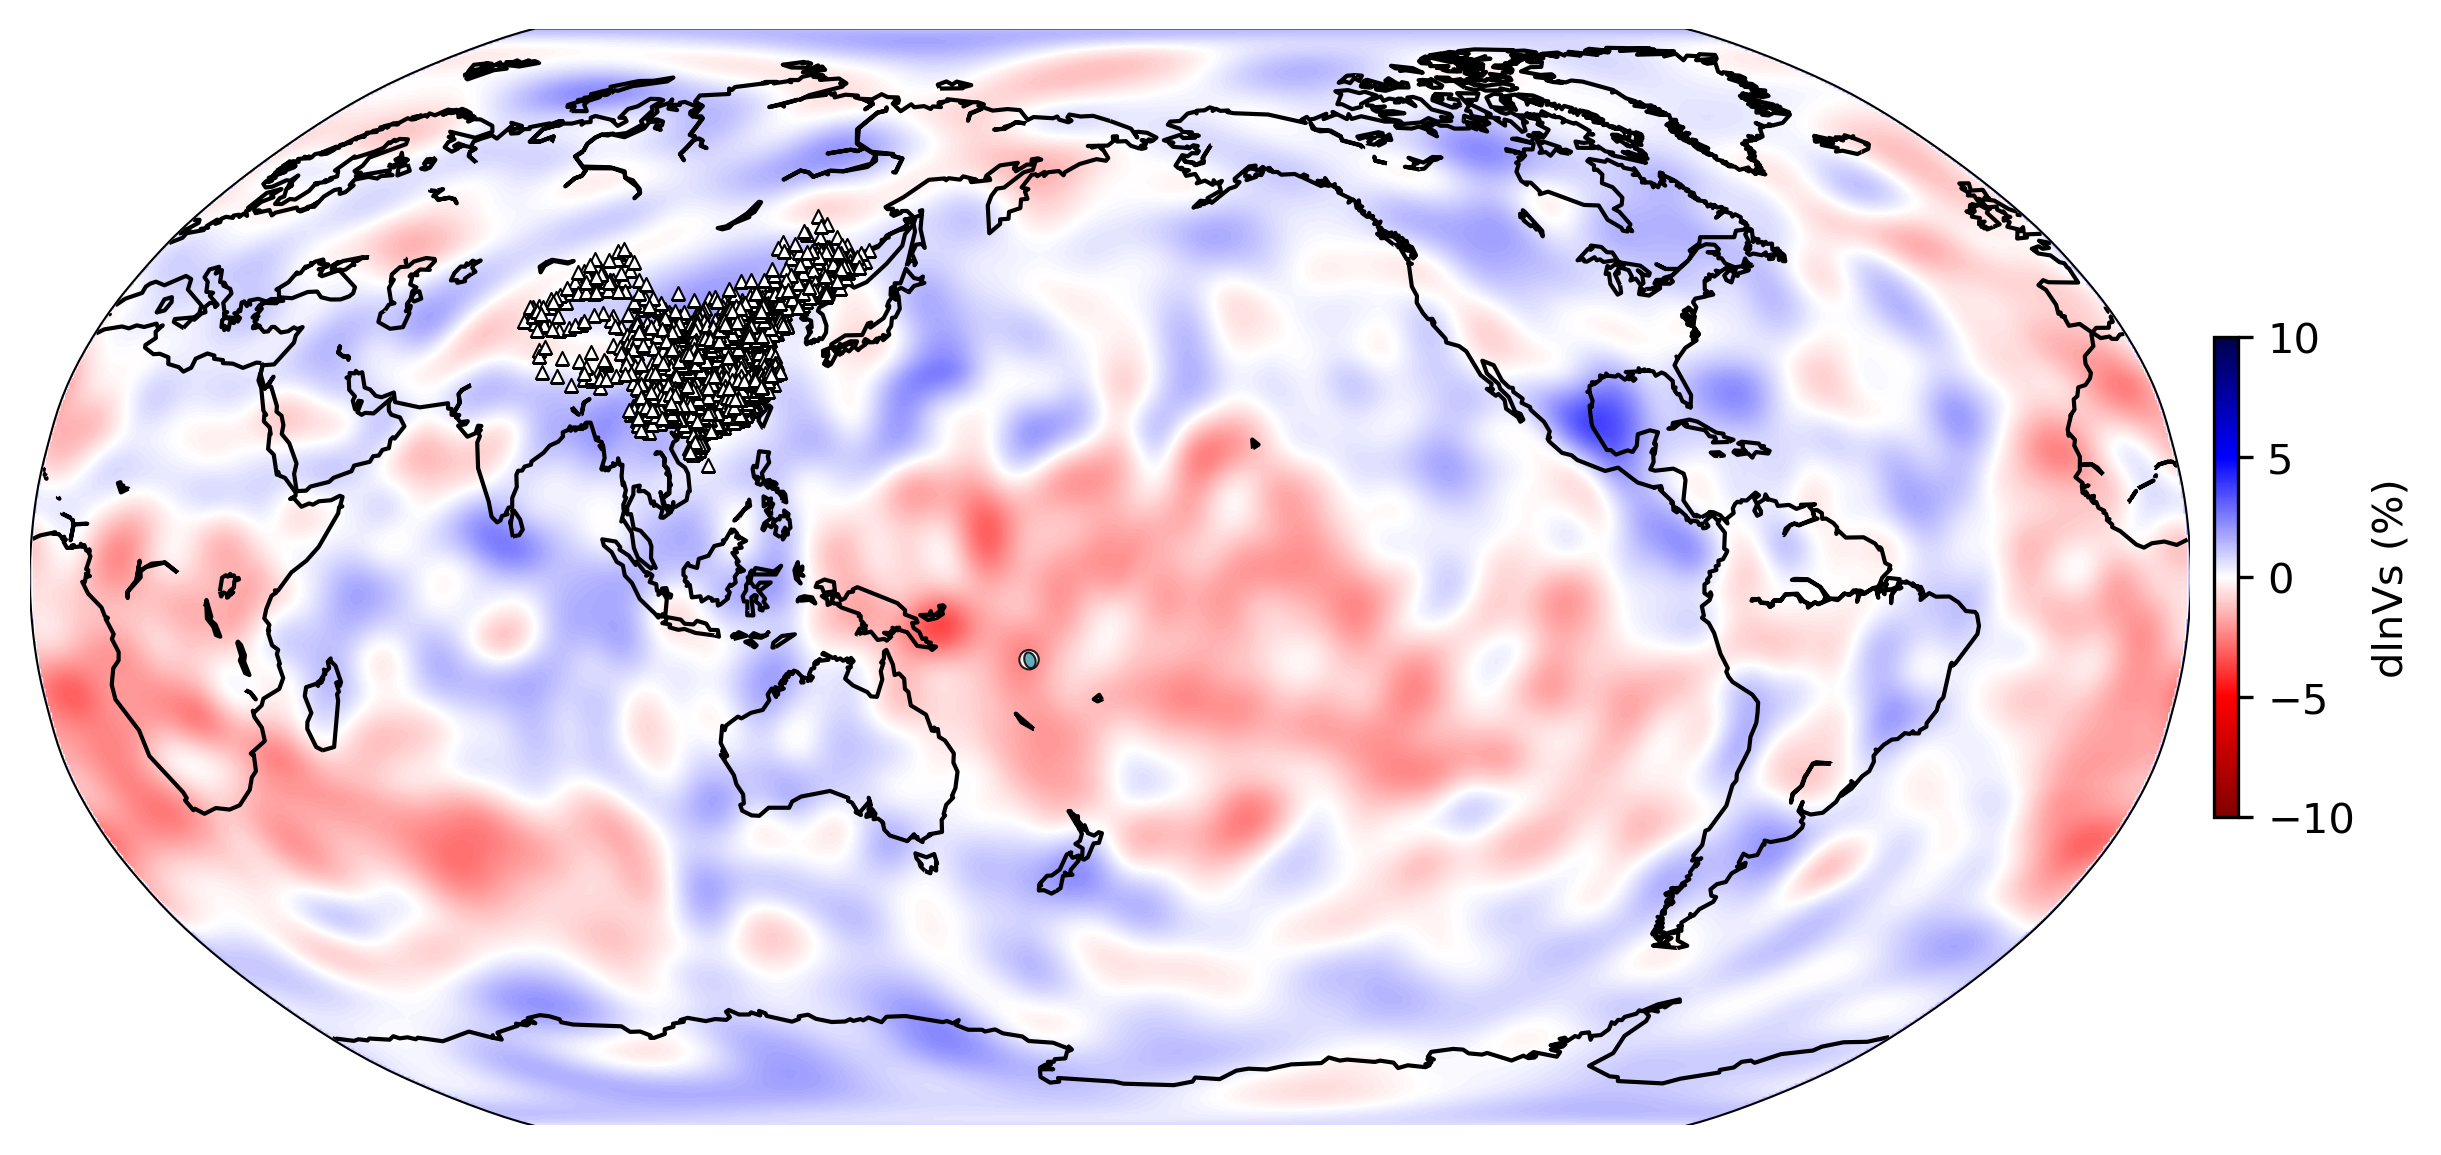

In [29]:
plot_model("../Data/BGPlottingData/SEMUCB_WM1_2800km.dat", -10.0, 10.0)
plt.savefig("../Figure/OverallRayCoverage_2800km.jpg")

In [30]:
CMTcatList = glob.glob('../Data/CMTSOLUTION/*.CMTSOLUTION')
len(CMTcatList)

790